# Forecasting chaotic time series

Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

Open this notebook in Google Colab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/forecasting_reservoir_computers.ipynb)


In [2]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# plt.style.use("dark_background")

# Forecasting as a supervised learning problem

Suppose we have a multivariate time series of the form $\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N$ where each $\mathbf{x}_t$ is a vector of length $D$ representing the state of the system at time $t$. We can think of this as a sequence of $N$ data points, each of which is a vector of length $D$. We can convert this into a supervised learning problem by creating a dataset of input-output pairs, where each input is a vector of length $D$ and the output is a vector of length $D$.

Using the notation for supervised learning models, our dataset $X$ is a matrix of size $N \times D$ and our target $y$ is a matrix of size $N \times D$. Each row of $X$ is an input vector $\mathbf{x}_t$ and the corresponding row of $y$ is the output vector $\mathbf{x}_{t+1}$:

$$
X = \begin{bmatrix}
\mathbf{x}_1 \\
\mathbf{x}_2 \\
\vdots \\
\mathbf{x}_{N-1}
\end{bmatrix} \in \mathbb{R}^{N \times D}
\quad \quad
y = \begin{bmatrix}
\mathbf{x}_2 \\
\mathbf{x}_3 \\
\vdots \\
\mathbf{x}_{N}
\end{bmatrix} \in \mathbb{R}^{N \times D}
$$

Creating a forecast model therefore consists of learning a function $f: \mathbb{R}^D \rightarrow \mathbb{R}^D$ that maps input vectors to output vectors. This function can be implemented using any supervised learning model, such as a neural network, decision tree, or linear regression.

Notice that our formulation of the forecasting problem implicity assumes that the system is Markovian. If we suspect that points in the distant past are relevant for predicting the future, we can include them as features in the input vectors. In this case, we would concatenate the past $p$ states to form the input vector $\mathbf{x}_t = [\mathbf{x}_{t-p}, \mathbf{x}_{t-p+1}, \ldots, \mathbf{x}_{t-1}]$. In this case, the input matrix $X$ would have size $N \times (D \cdot p)$. The parameter $p$ is commonly called the "lookback" of the model, and it loosely measures the expect memory (non-Markovianity) of the system.

We can explore time series forecasting using a simple chaotic system. The Lorenz system is a set of three ordinary differential equations that exhibit chaotic behavior.

Text(0, 0.5, 'z(t)')

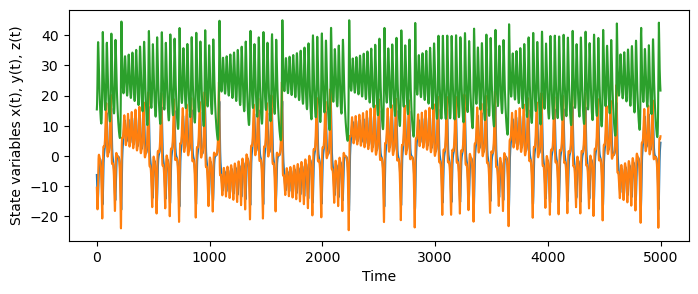

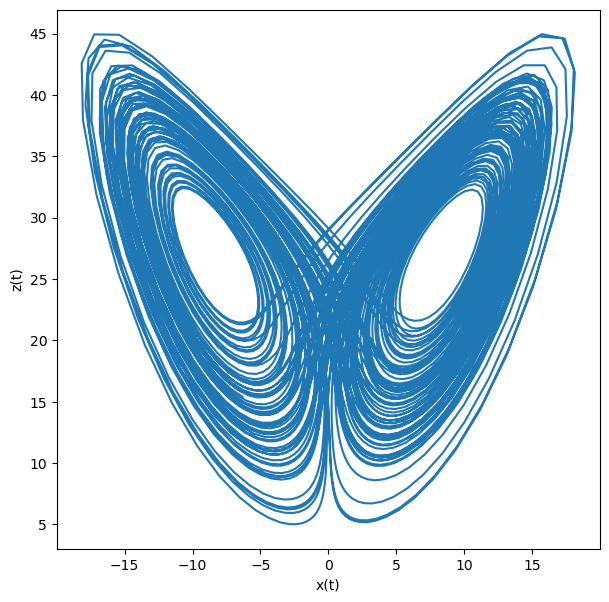

In [3]:
def lorenz(t, X):
    """Lorenz system."""
    x, y, z = X
    return np.array([10 * (y - x), x * (28 - z) - y, x * y - (8 / 3) * z])


from scipy.integrate import solve_ivp

## Initial conditions
X0 = np.array([-6.32, -10.53,  15.4])

## Time vector
t = np.linspace(0, 100, 5000)

## Numerically the system with scipy's built-in solver
sol = solve_ivp(lorenz, [min(t), max(t)], X0, t_eval=t, method="Radau")
X = np.copy(sol.y.T)

plt.figure(figsize=(8, 3))
plt.plot(sol.y.T)
plt.xlabel("Time")
plt.ylabel("State variables x(t), y(t), z(t)")

plt.figure(figsize=(7, 7))
plt.plot(sol.y[0], sol.y[2], "-")
plt.xlabel("x(t)")
plt.ylabel("z(t)")


Let's create a generic time series forecasting model, and then apply it to the Lorenz system.

In [4]:
class TimeSeriesForecaster:
    """A base class for time series forecasting models."""

    def __init__(self, lookback=1):
        self.lookback = lookback
        self.regressor = None
    
    def _convert_to_regression(self, X, p=1):
        """
        Given a time series, construct a regression dataset to pass to a supervised 
        learning model.

        Args:
            X (np.ndarray): A time series of shape (T, 1) or (T, D) for univariate or
                multivariate time series.
            p (int): The number of lags to include in the regression dataset.

        Returns:
            Xreg (np.ndarray): A regression dataset of shape (T - p, p) or (T - p, p * D)
                for univariate or multivariate time series.
            yreg (np.ndarray): The target values for the regression dataset, of shape
                (T - p, 1).
        
        """
        Xreg, yreg = [], []
        for i in range(p, len(X)):
            Xreg.append(X[i - p:i])
            yreg.append(X[i])
        return np.array(Xreg), np.array(yreg)
    
    def fit(self, X):
        X, y = self._convert_to_regression(X, p=self.lookback)
        print(X.shape, y.shape)
        self.regressor.fit(X, y)
        self.context = X[-1][None, :]
        print(self.context.shape)

    def step(self):
        """Predict one step into the future."""
        return self.regressor.predict(self.context)


from sklearn.linear_model import RidgeCV
class LinearForecaster(TimeSeriesForecaster):
    """A simple linear regression forecaster."""

    def __init__(self, lookback=1):
        super().__init__(lookback)
        self.regressor = RidgeCV()

# Split data
X_train, X_test = X[:4000], X[4000:]

## Instantiate the forecaster
linear_forecaster = LinearForecaster(lookback=10)

## Fit the forecaster
linear_forecaster.fit(X_train[:, 0])

## Predict the next 100 steps
y_pred = linear_forecaster.step()


print("True next timepoint: ", X[4000, 0])
print("Predicted next timepoint: ", y_pred[0])

(3990, 10) (3990,)
(1, 10)
True next timepoint:  -1.508741790092486
Predicted next timepoint:  -1.4736051158915169


# Autoregressive models enable long-horizon forecasting

We set up our regression problem as many-to-one: multiple context points are used to predict the next timepoint. But usually in forecasting, we are instead interested in predicting multiple timepoints into the future. One way we could do this is to change the shape of our output matrix $y$ to include multiple future timepoints. For example, we could set $y$ to be a matrix of size $N \times (D \cdot H)$, where the *horizon* $H$ is the number of timepoints we want to predict into the future. In this case, the output matrix $y$ would contain the future $H$ states of the system for each input vector $\mathbf{x}_t$.

However, this approach is not always practical. One reason is that the number of output dimensions grows linearly with the horizon, which means that the number of trainable parameters in our model scales with $H$.

Instead, we can generate long-horizon forecasts by iteratively applying our many-to-one model repeatedly. The idea is to use the model to predict the next timepoint, and then use the predicted timepoint as the input for the next prediction. This process can be repeated for as many timepoints as desired.

Mathematically, suppose we have a model $f: \mathbb{R}^D \rightarrow \mathbb{R}^D$ that predicts the next timepoint. We can use this model to generate a sequence of future states $\mathbf{x}_{t+1}, \mathbf{x}_{t+2}, \ldots, \mathbf{x}_{t+H}$ by iteratively applying the model:

$$
\mathbf{\hat{x}}_{t+1} = f(\mathbf{x}_t) \\
\mathbf{\hat{x}}_{t+2} = f(\mathbf{\hat{x}}_{t+1}) \\
\vdots \\
\mathbf{\hat{x}}_{t+H} = f(\mathbf{\hat{x}}_{t+H-1})
$$



+ One reason why long-term forecasting is harder than one-step forecasting comes from dynamical systems theory. If we suppose our time series is generated by a deterministic dynamical system, then a one-step forecast model essentially learns to approximate the first time derivative of the system. 

+ Let's overrride the `forecast` method to implement an autoregressive forecasting model. This method will take an input vector $\mathbf{x}_t$ and return a sequence of future states $\mathbf{x}_{t+1}, \mathbf{x}_{t+2}, \ldots, \mathbf{x}_{t+H}$.

(3980, 20) (3980,)
(1, 20)


Text(0, 0.5, '$x(t)$, $\\hat{x}(t)$')

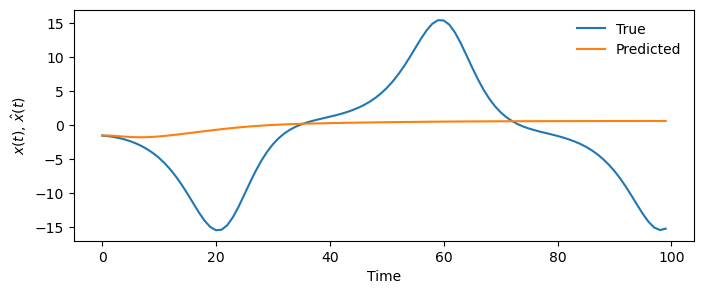

In [5]:
class AutoRegressiveForecaster(TimeSeriesForecaster):
    """An autoregressive forecaster."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def predict(self, horizon):
        """Use autoregressive model to predict future values."""
        preds = []
        for _ in range(horizon):
            pred = self.step()
            preds.append(pred)
            self.context = np.concatenate([self.context[0, 1:], pred])[None, :]
        return np.array(preds)

class LinearAutoRegressiveForecaster(AutoRegressiveForecaster):
    """An autoregressive forecaster using linear regression."""

    def __init__(self, lookback=1):
        super().__init__(lookback)
        self.regressor = RidgeCV()

## Instantiate the forecaster
model = LinearAutoRegressiveForecaster(lookback=20)

## Fit the forecaster
model.fit(X_train[:, 0])

## Predict the next 100 steps
y_pred = model.predict(100)

plt.figure(figsize=(8, 3))
plt.plot(X_test[:100, 0], label="True")
plt.plot(y_pred[:, 0], label="Predicted")
plt.legend(frameon=False)
plt.xlabel("Time")
plt.ylabel("$x(t)$, $\hat{x}(t)$")

## Scoring forecast models with horizoned error functions

When evaluating a forecast model, we need to consider how well it predicts the future. One common approach is to use a loss function that compares the predicted future states to the true future states. For example, we could use the mean squared error (MSE) between the predicted and true future states:

$$
\text{MSE} = \frac{1}{H} \sum_{i=1}^H ||\mathbf{\hat{x}}_{i} - \mathbf{x}_{i}||^2
$$
where, by convention, the index $0$ refers to the first timepoint not seen by our model. In some schemes, the indices into the context (the last timepoints seen by the model) are denoted by *negative* indices, so that $\mathbf{x}_{-1}$ is the last context point, $\mathbf{x}_{-2}$ is the second-to-last context point, and so on. Thus, the datapoint index $0$ is special in time series forecasting. This differs from other types of supervised learning, where the order of the data points is not important.

In practice, we may be more interested in the short-term predictions than the long-term predictions. In this case, we can use a horizoned loss function that shows how the prediction error changes as we look further into the future. This simply consists of a partial sum in the MSE:

$$
\text{H-MSE}(t) = \frac{1}{t} \sum_{i=1}^t ||\mathbf{\hat{x}}_{i} - \mathbf{x}_{i}||^2
$$

We can usually get better estimates of this quantity by averaging over many different predictions.

Text(0, 0.5, 'Mean Squared Error')

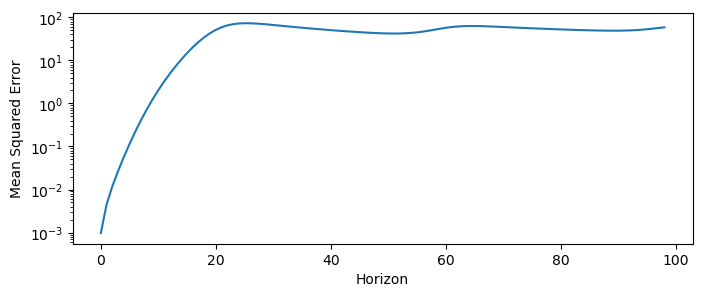

In [6]:
def mse_horizoned(y_true, y_pred):
    """Mean squared error for a horizon of predictions."""
    all_mse = list()
    for i in range(1, y_true.shape[0]):
        all_mse.append(np.mean((y_true[:i] - y_pred[:i]) ** 2))
    return all_mse

## Compute the MSE for each horizon
mse = mse_horizoned(X_test[:len(y_pred), 0], y_pred[:, 0])
plt.figure(figsize=(8, 3))
plt.semilogy(mse)
plt.xlabel("Horizon")
plt.ylabel("Mean Squared Error")


Notice that the MSE initially grows exponentially with the horizon, but then plateaus. This is a general phenomenon for chaotic systems, in which the prediction error grows exponentially at a characteristic rate that is an invariant property of the particular system:

$$
\text{MSE} \propto e^{\lambda H}
$$

where $\lambda$ is the Lyapunov exponent of the system. The Lyapunov exponent is an invariant quantity that measures of the system's sensitivity to initial conditions, and it quantifies how quickly nearby trajectories diverge from each other and thus the rate at which errors grow in a forecast model. Informally, dynamical systems with higher Lyapunov exponents are more chaotic and harder to predict.

For example, the Lorenz equations have a Lyapunov exponent of $\lambda \approx 0.9$. This means that the MSE of a forecast model for the Lorenz system will grow exponentially with a rate of $e^{0.9 H}$.

## Can we do any better with other supervised learning models?

A **Random Forest** is a powerful ensemble learning method that can be used for regression tasks. It is a collection of decision trees that are trained on different subsets of the data. The predictions of the individual trees are then averaged to produce the final prediction. Random forests are known for their robustness and ability to handle complex data.

(3980, 20) (3980,)
(1, 20)


Text(0, 0.5, 'Mean Squared Error')

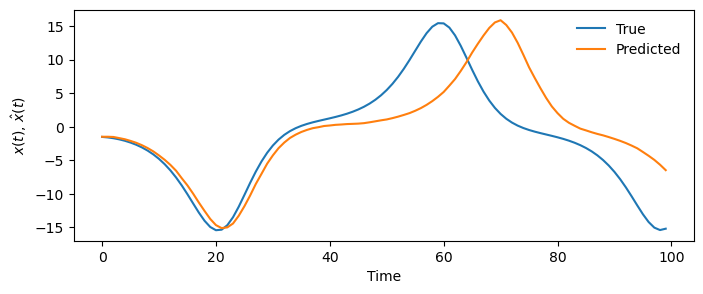

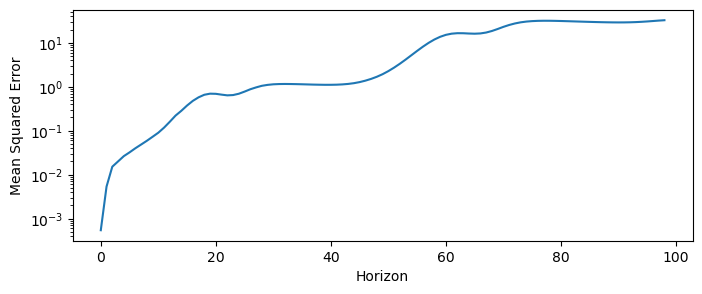

In [7]:
from sklearn.ensemble import RandomForestRegressor

class RandomForestForecaster(AutoRegressiveForecaster):
    """A random forest forecaster."""

    def __init__(self, lookback=1):
        super().__init__(lookback)
        self.regressor = RandomForestRegressor(n_estimators=100)

model = RandomForestForecaster(lookback=20)
model.fit(X_train[:, 0])
y_pred = model.predict(100)

plt.figure(figsize=(8, 3))
plt.plot(X_test[:100, 0], label="True")
plt.plot(y_pred[:, 0], label="Predicted")
plt.legend(frameon=False)
plt.xlabel("Time")
plt.ylabel("$x(t)$, $\hat{x}(t)$")

mse = mse_horizoned(X_test[:len(y_pred), 0], y_pred[:, 0])
plt.figure(figsize=(8, 3))
plt.semilogy(mse)
plt.xlabel("Horizon")
plt.ylabel("Mean Squared Error")

A **Multi-layer Perceptron (MLP)** is a type of neural network that consists of multiple layers of hidden matrix multiplications followed by elementwise nonlinearities. MLPs are known for their ability, in principle, to approximate any function, given enough data and training time.

(3980, 20) (3980,)
(1, 20)


Text(0, 0.5, 'Mean Squared Error')

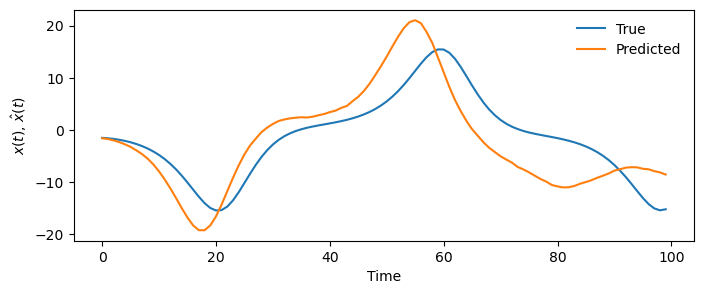

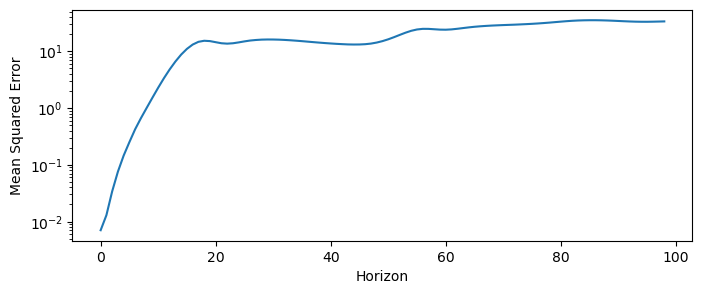

In [ ]:
from sklearn.neural_network import MLPRegressor

class MLPForecaster(AutoRegressiveForecaster):
    """A multi-layer perceptron forecaster."""

    def __init__(self, lookback=1):
        super().__init__(lookback)
        self.regressor = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000)

model = MLPForecaster(lookback=20)
model.fit(X_train[:, 0])
y_pred = model.predict(100)

plt.figure(figsize=(8, 3))
plt.plot(X_test[:100, 0], label="True")
plt.plot(y_pred[:, 0], label="Predicted")
plt.legend(frameon=False)
plt.xlabel("Time")
plt.ylabel("$x(t)$, $\hat{x}(t)$")

mse = mse_horizoned(X_test[:len(y_pred), 0], y_pred[:, 0])
plt.figure(figsize=(8, 3))
plt.semilogy(mse)
plt.xlabel("Horizon")
plt.ylabel("Mean Squared Error")



# Next-generation reservoir computers

[Next-generation reservoir computers](https://www.nature.com/articles/s41467-021-25801-2) perform ridge regression over a series of polynomial transformations fo time lags of the input data. This allows the model to capture non-linear dynamics in the data.
Matheamtically, the model is given by:

$$
\mathbf{y}_t = \mathbf{W} P(\mathbf{x}_t, \mathbf{x}_{t-1}, \ldots, \mathbf{x}_{t-p})
$$

where $P$ is a polynomial transformation that concatenates the input vectors $\mathbf{x}_t, \mathbf{x}_{t-1}, \ldots, \mathbf{x}_{t-p}$ into a single vector, and $\mathbf{W}$ is a matrix of weights that are learned by ridge regression.

(3997, 3) (3997,)
(1, 3)


Text(0, 0.5, 'Mean Squared Error')

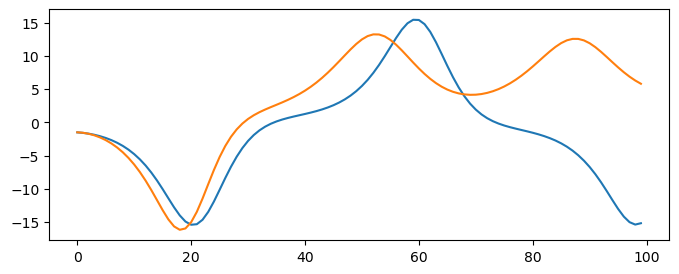

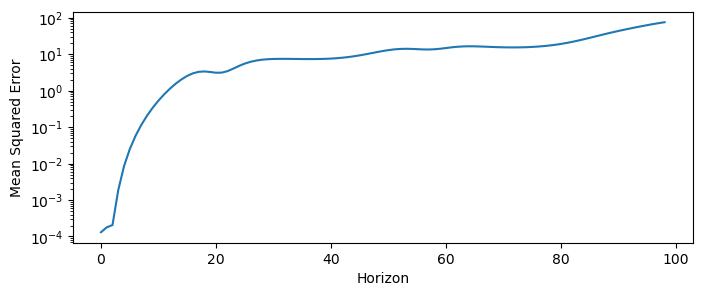

In [23]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

class ReservoirForecaster(AutoRegressiveForecaster):
    """
    A Reservoir Computer forecaster using deterministic polynomial featurization.

    Parameters:
        lookback (int): Number of lagged time steps to use as input features.
        max_power (int): Maximum degree of polynomial features.
    """

    def __init__(self, lookback=1, max_power=2):
        super().__init__(lookback=lookback)
        self.max_power = max_power
        # Define a pipeline with PolynomialFeatures and Ridge regression
        self.regressor = Pipeline([
            ('preprocessor', PolynomialFeatures(degree=self.max_power, include_bias=False)),
            ('ridge', RidgeCV())
        ])
        self.preprocessor = self.regressor.named_steps['preprocessor']

    def score(self, X, y): # r^2
        r2 = self.regressor.score(X, y)
    
    def get_params(self, deep=True):
        return {'lookback': self.lookback, 'max_power': self.max_power}
    
    def set_params(self, **params):
        self.lookback = params['lookback']
        self.max_power = params['max_power']
        self.regressor = Pipeline([
            ('preprocessor', PolynomialFeatures(degree=self.max_power, include_bias=False)),
            ('ridge', RidgeCV())
        ])
        self.preprocessor = self.regressor.named_steps['preprocessor']
        return self
        
model = ReservoirForecaster(lookback=3, max_power=4)
model.fit(X_train[:, 0])
y_pred = model.predict(100)

plt.figure(figsize=(8, 3))
plt.plot(X_test[:len(y_pred), 0], label="True")
plt.plot(y_pred[:, 0], label="Predicted")


mse = mse_horizoned(X_test[:len(y_pred), 0], y_pred[:, 0])
plt.figure(figsize=(8, 3))
plt.semilogy(mse)
plt.xlabel("Horizon")
plt.ylabel("Mean Squared Error")

# Can we do better? Hyperparameter tuning using GridSearchCV

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_power': [1,2,3,4], "lookback": [1, 2, 3]}
grid = GridSearchCV(ReservoirForecaster(), param_grid, cv=5)
grid.fit(X_train[:, 0])

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
# print("Test set score: {:.2f}".format(grid.score(X_test[:, 0])))


(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3199, 1) (3199,)
(1, 1)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)
(3198, 2) (3198,)
(1, 2)


(3999, 1) (3999,)
(1, 1)


Text(0, 0.5, 'Mean Squared Error')

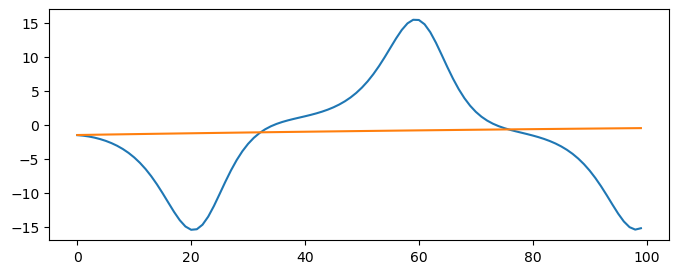

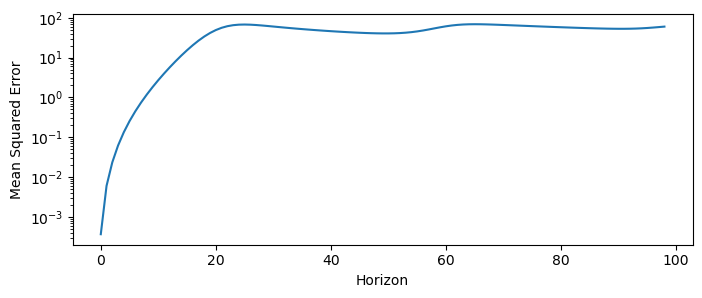

In [25]:
model = ReservoirForecaster(lookback=grid.best_params_['lookback'], max_power=grid.best_params_['max_power'])
model.fit(X_train[:, 0])
y_pred = model.predict(100)

plt.figure(figsize=(8, 3))
plt.plot(X_test[:len(y_pred), 0], label="True")
plt.plot(y_pred[:, 0], label="Predicted")


mse = mse_horizoned(X_test[:len(y_pred), 0], y_pred[:, 0])
plt.figure(figsize=(8, 3))
plt.semilogy(mse)
plt.xlabel("Horizon")
plt.ylabel("Mean Squared Error")